In [78]:
%run ../../../__init__.py
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Training loss

In [79]:
from omegaconf import OmegaConf
from hydra import compose, initialize

model = 'shiness_disk/default'
# model = 'dohness_disk/default'
# model = 'logness_disk/default'
# model = 'harris_disk/default'

train_overrides = [f"+models/{model}=custom",
                   "+datasets/megadepth/setup/CUSTOM=train",
                   "+experiment=custom"]

with initialize(config_path="../../../../config"):
    config = compose(overrides=train_overrides)
    
    print(OmegaConf.to_yaml(config))
    
    OmegaConf.set_struct(config, False)
    
    experiment = SummertimeExperiment(config)
    batch, endpoint, metrics = experiment.run()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  del sys.path[0]


models:
  shiness:
    input_size_divisor: 16
    modules:
      detector:
        idx: 0
        default_idx: 0
        process_idx: 0
        ness:
          feature_channels: 3
          down:
          - 16
          - 32
          - 64
          - 64
          - 64
          up:
          - 64
          - 64
          - 64
          - 1
          min_ness: 0.0
          max_ness: 32.0
        shi:
          sobel_size: 3
          window_size: 3
          window_cov: 2
          loc: true
    eval_params:
      nms_size: 5
      score_thresh: 0.0
    checkpoint:
      rel_path: models/shiness
      name: r_mAA=0.7706
  disk:
    input_channels: 3
    input_size_divisor: 16
    modules:
      descriptor:
        idx: 1
        default_idx: 1
        process_idx: 1
    checkpoint:
      name: depth-save
      rel_path: models/disk
      remap: true
    eval_params:
      matcher:
        name: l2
  model_name: shiness_disk
datasets:
  megadepth:
    custom:
      csv_path: /mnt/sda/

In [80]:
from copy import deepcopy

ness_detector = deepcopy(experiment.model_wrapper.modules_wrappers[0].detector)

scale_factor = 2.0
num_samples = 100

config = OmegaConf.create({'topk': 1024,
                           'nms_size': 5,
                           'score_thresh': 0.0})

patch_size = config.nms_size + ness_detector.base_detector.get_border_size() * 2
scaled_patch_size = int(patch_size * scale_factor) // 2 * 2 + 1

ness_detector.base_detector.set_border_size(scaled_patch_size + int(4 * scale_factor))
ness_detector.base_detector.set_loc(False)

In [81]:
import source.models.ness.modules_wrappers.namespace as n_ns

image = batch[du.IMAGE1]
image_gray = batch[du.IMAGE_GRAY1]
ness = endpoint[n_ns.NESS1]

In [82]:
kp, kp_score, kp_base_score = ness_detector(image_gray, ness.detach(), config)

In [83]:
from source.models.ness.criteria.homography import generate_homographies

kp_mask = kp_base_score > config.score_thresh

h_data = generate_homographies(scaled_patch_size,
                               scale_factor, num_samples,
                               experiment.device)

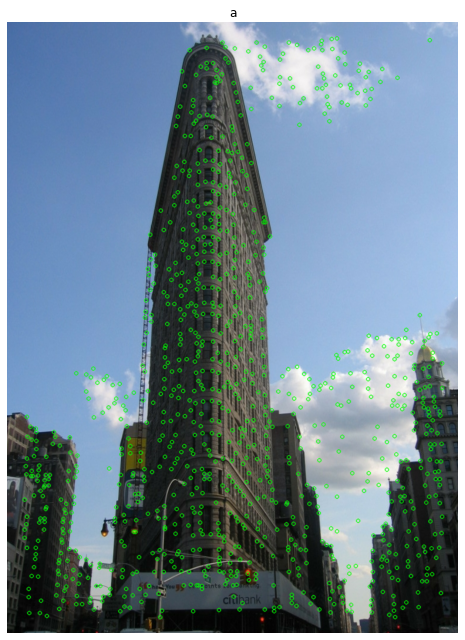

In [84]:
plot_figures({'a': draw_cv_keypoints(image, kp, draw_mask=kp_mask)}, 1, 1, (16, 9))

In [85]:
from source.models.ness.criteria.keypoint_scores import get_stability_score

kp_ss = get_stability_score(image_gray, kp, h_data,
                            scaled_patch_size, patch_size,
                            num_samples,
                            config.topk, config.nms_size,
                            ness_detector.base_detector)

In [86]:
from source.utils.endpoint_utils import sample_tensor

kp_ness = sample_tensor(ness, kp, ness.shape).squeeze(-1)

In [87]:
from source.models.ness.criteria.mse_loss import mse_loss

mse_loss(kp_ness, kp_ss, kp_mask)

tensor(1.7666)

(array([412., 256., 172.,  86.,  59.,  21.,   7.,   8.,   1.,   2.]),
 array([3.2671665e-12, 1.4209895e+00, 2.8419790e+00, 4.2629685e+00,
        5.6839581e+00, 7.1049476e+00, 8.5259371e+00, 9.9469271e+00,
        1.1367916e+01, 1.2788906e+01, 1.4209895e+01], dtype=float32),
 <BarContainer object of 10 artists>)

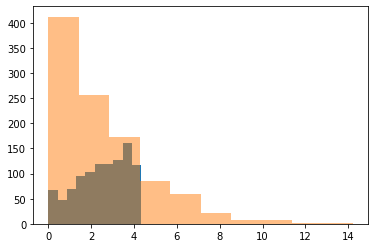

In [88]:
plt.hist(kp_ness[0, kp_mask[0]].numpy())
plt.hist(kp_ss[0, kp_mask[0]].numpy(), alpha=0.5)

## Homography sampling visualization

In [89]:
b = image_gray.shape[0]
k = config.topk
bk = b * k
kn = k * num_samples
bkn = bk * num_samples

In [90]:
from source.utils.endpoint_utils import sample_tensor_patch

ig_patch = sample_tensor_patch(image_gray, kp, scaled_patch_size, image_gray.shape).squeeze(-1).\
    view(b, k, 1, scaled_patch_size, scaled_patch_size)

i_patch = sample_tensor_patch(image, kp, scaled_patch_size, image_gray.shape).squeeze(-1).\
    view(b, k, scaled_patch_size, scaled_patch_size, 3).permute(0, 1, 4, 2, 3)

In [91]:
from source.projective.warp import warp_points
from source.utils.endpoint_utils import create_patch_grid

center = torch.tensor([scaled_patch_size // 2 + 0.5], device=kp.device). \
        view(1, 1, 1). \
        repeat(num_samples, 1, 2)

w_center = warp_points(center, h_data)[0]
w_center_nn = w_center.long() + 0.5

w_center_nn_pg = create_patch_grid(w_center_nn.
                                   permute(1, 0, 2),
                                   scaled_patch_size, image_gray.shape). \
        permute(1, 0, 2, 3). \
        view(num_samples, -1, 2)

ww_center_nn_pg = warp_points(w_center_nn_pg, h_data.swap())[0].view(num_samples, 1, -1, 2)
ww_center_nn_pg = ww_center_nn_pg.view(b, 1, num_samples, -1, 2).repeat(1, k, 1, 1, 1)

w_i_patch = sample_tensor_patch(i_patch.view(bk, 3, scaled_patch_size, scaled_patch_size),
                                ww_center_nn_pg.view(bk, num_samples, -1, 2), 
                                scaled_patch_size, (bk, 3, scaled_patch_size, scaled_patch_size))
w_i_patch = w_i_patch.view(b, k, num_samples, scaled_patch_size, scaled_patch_size, 3).permute(0, 1, 2, 5, 3, 4)

w_ig_patch = sample_tensor_patch(ig_patch.view(bk, 1, scaled_patch_size, scaled_patch_size),
                                ww_center_nn_pg.view(bk, num_samples, -1, 2),
                                scaled_patch_size, (bk, 1, scaled_patch_size, scaled_patch_size))
w_ig_patch = w_ig_patch.view(b, k, num_samples, 1, scaled_patch_size, scaled_patch_size)

In [92]:
w_ig_patch_center = (torch.tensor([scaled_patch_size // 2 + 0.5], device=kp.device).
                         view(1, 1, 1).
                         repeat(num_samples, 1, 2)
                         + (w_center - w_center_nn)). \
        view(1, 1, num_samples, 1, 2). \
        repeat(b, k, 1, 1, 1). \
        view(bkn, 1, 2)

w_ig_inner_patch = sample_tensor_patch(w_ig_patch.view(bkn, 1, scaled_patch_size, scaled_patch_size),
                                       w_ig_patch_center,
                                       patch_size, (bkn, 1, scaled_patch_size, scaled_patch_size)). \
            view(b, k, num_samples, 1, patch_size, patch_size)

In [93]:
from source.models.shi.module import get_shi_score
from source.utils.endpoint_utils import mask_border

sobel_size = 3
window_size = 3 
window_cov = 2

nms_border = (patch_size - config.nms_size) // 2

w_shi_patch = get_shi_score(w_ig_inner_patch.view(bkn, 1 , patch_size, patch_size),
                            sobel_size, window_size, window_cov)
w_shi_patch = w_shi_patch.view(b, k, num_samples, 1, patch_size, patch_size)[:, :, :, :,
                                                                             nms_border:-nms_border,
                                                                             nms_border:-nms_border]
w_ig_inner_patch = w_ig_inner_patch[:, :, :, :,
                                    nms_border:-nms_border,
                                    nms_border:-nms_border]

In [94]:
left, right = scaled_patch_size // 2 - config.nms_size // 2, scaled_patch_size // 2 + config.nms_size // 2 + 1
shi_patch = get_shi_score(ig_patch.view(bk, 1 , scaled_patch_size, scaled_patch_size),
                          sobel_size, window_size, window_cov)[:, :, left:right, left:right]

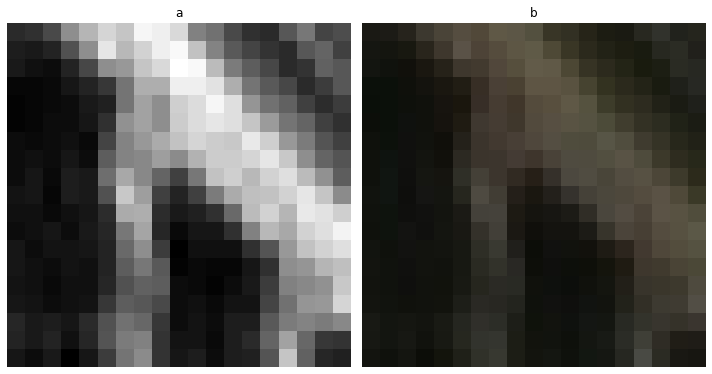

In [95]:
kp_idx = 280

plot_figures({'a': torch2cv(ig_patch[0, kp_mask[0]][kp_idx]),
              'b': torch2cv(i_patch[0, kp_mask[0]][kp_idx])}, 1, 2, (10, 9))

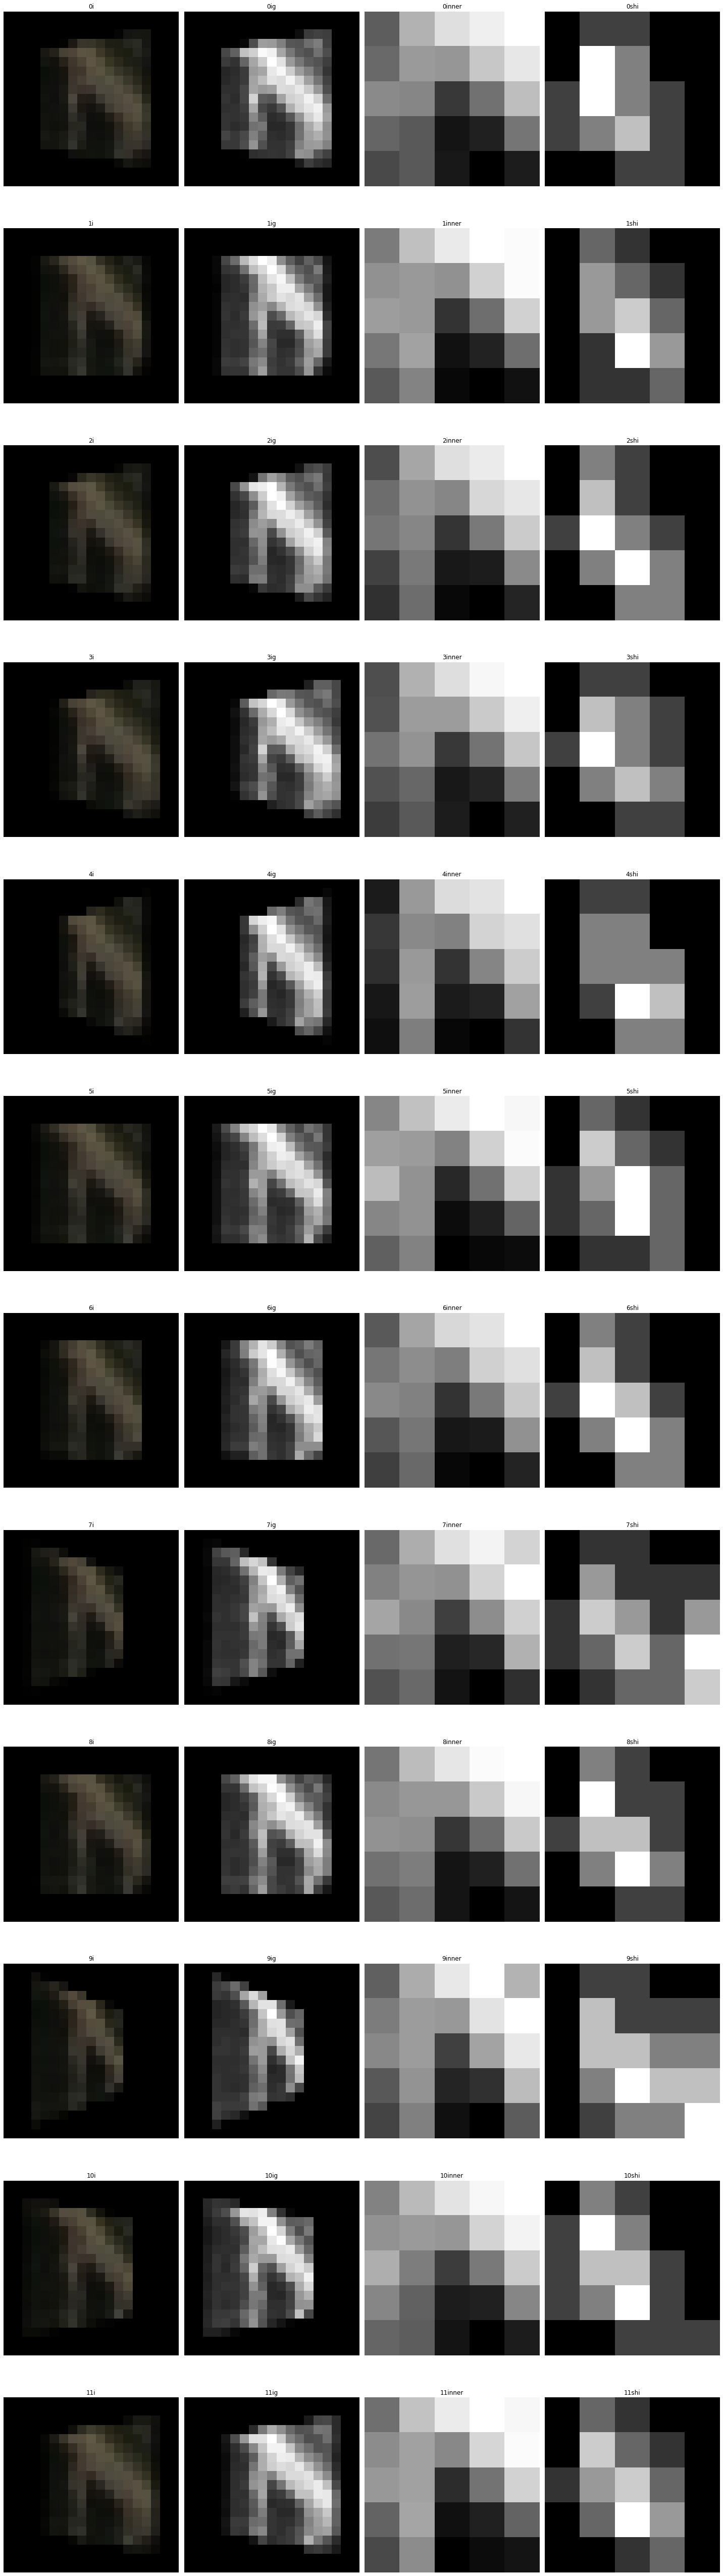

In [96]:
num_plots = 12

plot_dict = {}

for i in range(0, num_plots):
    plot_dict[str(i)+ 'i'] = torch2cv(w_i_patch[0, kp_mask[0]][kp_idx][i])
    plot_dict[str(i)+'ig'] = torch2cv(w_ig_patch[0, kp_mask[0]][kp_idx][i])
    plot_dict[str(i) + 'inner'] = torch2cv(w_ig_inner_patch[0, kp_mask[0]][kp_idx][i])
    plot_dict[str(i) + 'shi'] = torch2cv(w_shi_patch[0, kp_mask[0]][kp_idx][i])
    
plot_figures(plot_dict, num_plots, 4, (20, 6 * num_plots))

In [97]:
# from source.utils.vis_utils import draw_crosshair

# fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(18, 9))

# axes = axes.ravel()

# for i in range(8):
#     axes[i].set_axis_off()
    
# h_idx1 = 0
# h_idx2 = 20
# h_idx3 = 42
    
# axes[0].imshow(torch2cv(i_patch[0, kp_mask[0]][kp_idx]))
# axes[1].imshow(torch2cv(w_i_patch[0, kp_mask[0]][kp_idx][h_idx1]))
# axes[2].imshow(torch2cv(w_i_patch[0, kp_mask[0]][kp_idx][h_idx2]))
# axes[3].imshow(torch2cv(w_i_patch[0, kp_mask[0]][kp_idx][h_idx3]))

# draw_crosshair(axes[0], [scaled_patch_size // 2 , scaled_patch_size // 2])
# draw_crosshair(axes[1], ww_center_nn_pg[0][kp_mask[0]][kp_idx][h_idx1][180].long(), 'red')
# draw_crosshair(axes[2], ww_center_nn_pg[0][kp_mask[0]][kp_idx][h_idx2][180].long(), 'red')
# draw_crosshair(axes[3], ww_center_nn_pg[0][kp_mask[0]][kp_idx][h_idx3][180].long(), 'red')

# axes[4].imshow(torch2cv(shi_patch[kp_mask[0]][kp_idx], normalize=True), cmap='gray')
# axes[5].imshow(torch2cv(w_shi_patch[0, kp_mask[0]][kp_idx][h_idx1], normalize=True), cmap='gray')
# axes[6].imshow(torch2cv(w_shi_patch[0, kp_mask[0]][kp_idx][h_idx2], normalize=True), cmap='gray')
# axes[7].imshow(torch2cv(w_shi_patch[0, kp_mask[0]][kp_idx][h_idx3], normalize=True), cmap='gray')

# center = [config.nms_size // 2, config.nms_size // 2]

# draw_crosshair(axes[4], center)
# draw_crosshair(axes[5], center, 'red')
# draw_crosshair(axes[6], center, 'red')
# draw_crosshair(axes[7], center, 'red')

# plt.tight_layout()

# plt.savefig('image_artifacts.pdf')